# **Chapter 17. Decision Trees**

## What is a **Decision Tree**?

* A decision tree uses a tree structure to represent a number of possible decision paths and an outcome for each path.
* If you have ever played the game **Twenty Questions**, then you are familiar with decision trees. For example:
>* "I am thinking of an animal."
>* "Does it have more than five legs?"
>* "No."
>* "Is it delicious?"
>* "No."
>* "Does it appear on the back of the Australian five-cent coin?"
>* "Yes."
>* "Is it an echidna(바늘두더지)?"
>* "Yes, it is!"

* This corresponds to the path: "Not more than 5 legs" $\rightarrow$ "Not delicious" $\rightarrow$ "On the 5-cent coin" $\rightarrow$ "Echidna!"

![picture](https://drive.google.com/uc?id=1DdprSGfdNJugbWKuuVk3_JeyFJkvJ2AX)

* Decision trees are very easy to understand and interpret, and the process by which they reach a prediction is completely transparent.

* Decision trees can easily handle a mix of numeric (e.g., number of legs) and categorical (e.g., delicious/not delicious) attributes and can even classify data for which attributes are missing.

* At the same time, finding an "optimal" decision tree for a set of training data is computationally a very hard problem. We will get around this by trying to build a good enough tree rather than an optimal one, although for large datasets this can still be a lot of work.

* More important, it is very easy (and very bad) to build decision trees that are overfitted to the training data, and that don't generalize well to unseen data.

* We will work through the **ID3** algorithm for learning a
decision tree from a set of labeled data.
>* CART, ID3, and C4.5 algorithms are the representative algorithms.

## **Entropy**

* In order to build a decision tree, we will need to decide _what questions to ask_ and _in what order_. 
>* At each stage of the tree there are some possibilities we've eliminated and some that we haven't. After learning that an animal doesn't have more than five legs, we've eliminated the possibility that it's a grasshopper. We haven't eliminated the possibility that it's a duck. Each possible question partitions the remaining possibilities according to its answer.

* Ideally, we'd like to choose questions whose answers give a lot of information about what our tree should predict. 
>* If there's a single yes/no question for which "yes" answers always correspond to `True` outputs and "no" answers to `False` outputs (or vice versa), this would be an awesome question to pick. Conversely, a yes/no question
for which neither answer gives you much new information about what the prediction should be is probably not a good choice.

![picture](https://drive.google.com/uc?id=1_PK8z-NAvzPUqrzBgQnN3PlCQIliHgzd)

* Imagine that we have a set $S$ of data, each member of which is labeled as belonging to one of a finite number of classes $C_1, \ldots, C_n$. If all the data points belong to a single class, then there is no real uncertainty, which means we'd like there to be *low* entropy. If the data points are evenly spread across the classes, there is a lot of uncertainty and we'd like there to be *high* entropy.

![picture](https://drive.google.com/uc?id=1zFP-AirUZTHipNp47kT8HaFobzJ3vSfe)

![picture](https://drive.google.com/uc?id=1BaMjxjoH5O8eV9bhJrAFffepx5E56G6Z)

* In math terms, if $p_i$ is the proportion of data labeled as class $c_i$, we define the entropy as: $$H(S) = -p_1\log_2 p_1-\cdots-p_n\log_2 p_n $$

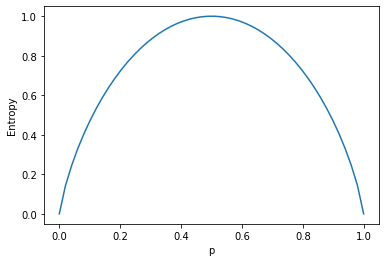

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

x = np.linspace(0,1)
y = entropy([x, 1-x], base=2)

plt.plot(x, y)
plt.xlabel('p')
plt.ylabel('Entropy')
plt.show()

In [ ]:
from typing import List
import math

def entropy(class_probabilities: List[float]) -> float:
    """Given a list of class probabilities, compute the entropy"""
    return sum(-p * math.log(p, 2)
               for p in class_probabilities
               if p > 0)                     # ignore zero probabilities

assert entropy([1.0]) == 0
assert entropy([0.5, 0.5]) == 1
assert 0.81 < entropy([0.25, 0.75]) < 0.82

from typing import Any
from collections import Counter

def class_probabilities(labels: List[Any]) -> List[float]:
    total_count = len(labels)
    return [count / total_count
            for count in Counter(labels).values()]

def data_entropy(labels: List[Any]) -> float:
    return entropy(class_probabilities(labels))

assert data_entropy(['a']) == 0
assert data_entropy([True, False]) == 1
assert data_entropy([3, 4, 4, 4]) == entropy([0.25, 0.75])

## **The Entropy of a Partition**

* We'd like some notion of the entropy that results from partitioning a set of data in a certain way. We want a partition to have low entropy if it splits the data into subsets that themselves have low entropy (i.e., are highly certain), and high entropy if it contains subsets that (are large and) have high entropy (i.e., are highly uncertain).

* Mathematically, if we partition our data $S$ into subsets $S_1, \ldots, S_m$ containing proportions $q_1, \ldots, q_m$ of the data, then we compute the entropy of the partition as a weighted sum:
$$H = q_1H(S_1) +\cdots+q_mH(S_m)$$

* The difference in the entropy before and after the split is called the **information gain**.

In [ ]:
def partition_entropy(subsets: List[List[Any]]) -> float:
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)

    return sum(data_entropy(subset) * len(subset) / total_count
               for subset in subsets)

## **Creating a Decisin Tree**

* Our tree will consist of **decision nodes** (which ask a question and direct us differently depending on the answer) and **leaf nodes** (which give us a prediction). We will build it using the relatively simple **ID3** algorithm, which operates in the following manner. Let's say we're given some labeled data, and a list of attributes to consider branching on:
>* If the data all have the same label, create a leaf node that predicts that label and then stop.
>* If the list of attributes is empty (i.e., there are no more possible questions to ask), create a leaf node that predicts the most common label and then stop.
>* Otherwise, try partitioning the data by each of the attributes.
>* Choose the partition with the lowest partition entropy.
>* Add a decision node based on the chosen attribute.
>* Recur on each partitioned subset using the remaining attributes.

In [ ]:
from typing import NamedTuple, Optional

class Candidate(NamedTuple):
    level: str
    lang: str
    tweets: bool
    phd: bool
    did_well: Optional[bool] = None  # allow unlabeled data

                  #  level     lang     tweets  phd  did_well
inputs = [Candidate('Senior', 'Java',   False, False, False),
          Candidate('Senior', 'Java',   False, True,  False),
          Candidate('Mid',    'Python', False, False, True),
          Candidate('Junior', 'Python', False, False, True),
          Candidate('Junior', 'R',      True,  False, True),
          Candidate('Junior', 'R',      True,  True,  False),
          Candidate('Mid',    'R',      True,  True,  True),
          Candidate('Senior', 'Python', False, False, False),
          Candidate('Senior', 'R',      True,  False, True),
          Candidate('Junior', 'Python', True,  False, True),
          Candidate('Senior', 'Python', True,  True,  True),
          Candidate('Mid',    'Python', False, True,  True),
          Candidate('Mid',    'Java',   True,  False, True),
          Candidate('Junior', 'Python', False, True,  False)
         ]

from typing import Dict, TypeVar
from collections import defaultdict

T = TypeVar('T')  # generic type for inputs

def partition_by(inputs: List[T], attribute: str) -> Dict[Any, List[T]]:
    """Partition the inputs into lists based on the specified attribute."""
    partitions: Dict[Any, List[T]] = defaultdict(list)
    for input in inputs:
        key = getattr(input, attribute)  # value of the specified attribute
        partitions[key].append(input)    # add input to the correct partition
    return partitions

def partition_entropy_by(inputs: List[Any],
                         attribute: str,
                         label_attribute: str) -> float:
    """Compute the entropy corresponding to the given partition"""
    # partitions consist of our inputs
    partitions = partition_by(inputs, attribute)

    # but partition_entropy needs just the class labels
    labels = [[getattr(input, label_attribute) for input in partition]
              for partition in partitions.values()]

    return partition_entropy(labels)

for key in ['level','lang','tweets','phd']:
    print(key, partition_entropy_by(inputs, key, 'did_well'))

assert 0.69 < partition_entropy_by(inputs, 'level', 'did_well')  < 0.70
assert 0.86 < partition_entropy_by(inputs, 'lang', 'did_well')   < 0.87
assert 0.78 < partition_entropy_by(inputs, 'tweets', 'did_well') < 0.79
assert 0.89 < partition_entropy_by(inputs, 'phd', 'did_well')    < 0.90

senior_inputs = [input for input in inputs if input.level == 'Senior']

assert 0.4 == partition_entropy_by(senior_inputs, 'lang', 'did_well')
assert 0.0 == partition_entropy_by(senior_inputs, 'tweets', 'did_well')
assert 0.95 < partition_entropy_by(senior_inputs, 'phd', 'did_well') < 0.96

level 0.6935361388961919
lang 0.8601317128547441
tweets 0.7884504573082896
phd 0.8921589282623617


![picture](https://drive.google.com/uc?id=1B_Acd0OoJfG4NacP5U_WN8CHMqFz9pH6)

## **Putting It All Together**

* We would like to implement it more generally.

In [ ]:
from typing import NamedTuple, Union, Any

class Leaf(NamedTuple):
    value: Any

class Split(NamedTuple):
    attribute: str
    subtrees: dict
    default_value: Any = None

DecisionTree = Union[Leaf, Split]

hiring_tree = Split('level', {   # First, consider "level".
    'Junior': Split('phd', {     # if level is "Junior", next look at "phd"
        False: Leaf(True),       #   if "phd" is False, predict True
        True: Leaf(False)        #   if "phd" is True, predict False
    }),
    'Mid': Leaf(True),           # if level is "Mid", just predict True
    'Senior': Split('tweets', {  # if level is "Senior", look at "tweets"
        False: Leaf(False),      #   if "tweets" is False, predict False
        True: Leaf(True)         #   if "tweets" is True, predict True
    })
})

def classify(tree: DecisionTree, input: Any) -> Any:
    """classify the input using the given decision tree"""

    # If this is a leaf node, return its value
    if isinstance(tree, Leaf):
        return tree.value

    # Otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values of are subtrees to consider next
    subtree_key = getattr(input, tree.attribute)

    if subtree_key not in tree.subtrees:   # If no subtree for key,
        return tree.default_value          # return the default value.

    subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
    return classify(subtree, input)        # and use it to classify the input.

def build_tree_id3(inputs: List[Any],
                   split_attributes: List[str],
                   target_attribute: str) -> DecisionTree:
    # Count target labels
    label_counts = Counter(getattr(input, target_attribute)
                           for input in inputs)
    most_common_label = label_counts.most_common(1)[0][0]

    # If there's a unique label, predict it
    if len(label_counts) == 1:
        return Leaf(most_common_label)

    # If no split attributes left, return the majority label
    if not split_attributes:
        return Leaf(most_common_label)

    # Otherwise split by the best attribute

    def split_entropy(attribute: str) -> float:
        """Helper function for finding the best attribute"""
        return partition_entropy_by(inputs, attribute, target_attribute)

    best_attribute = min(split_attributes, key=split_entropy)

    partitions = partition_by(inputs, best_attribute)
    new_attributes = [a for a in split_attributes if a != best_attribute]

    # recursively build the subtrees
    subtrees = {attribute_value : build_tree_id3(subset,
                                                 new_attributes,
                                                 target_attribute)
                for attribute_value, subset in partitions.items()}

    return Split(best_attribute, subtrees, default_value=most_common_label)

tree = build_tree_id3(inputs,
                      ['level', 'lang', 'tweets', 'phd'],
                      'did_well')

# Should predict True
assert classify(tree, Candidate("Junior", "Java", True, False))

# Should predict False
assert not classify(tree, Candidate("Junior", "Java", True, True))

# Should predict True
assert classify(tree, Candidate("Intern", "Java", True, True))

## **Using scikit-learn**

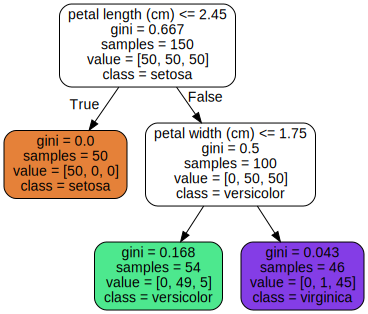

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file("iris_tree.dot")